# Policy Gradients
Based on https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

Setup the notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_in_jupyter(frames):
    """
    Thanks to http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html
    Install JSAnimation: pip3 install git+https://github.com/jakevdp/JSAnimation.git --user
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    

Let's implement a simple PG algorithm!

We will be using a very simple environment, the CartPole-v0. The state of the environment is represented as a 4-dimensional vector. So, let's define our policy (network) that we will be using to control the agent. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(x), dim=1)
        return out



Our agent outputs the probability for each action. We also need a way to sample the action to perform using these probabilities:

In [3]:
def select_action(net, state):
    # Convert state to a torch array
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = net(state)
    dist = Categorical(probs)
    action = dist.sample()
    
    # Keep the probability for calculating the loss (recall that we need log(\pi(s, a))
    # Note that this is actually part of the computationall graph!
    action_log_prob =  dist.log_prob(action)
    action = action.item()
    return action, action_log_prob


We also need a way to train the agent!

In [4]:
def train_net_on_path(optimizer, action_log_probs, rewards, gamma=0.99, eps=1e-7):
    policy_loss = []
    
    # Calculate the discounted reward for each step during the training
    # Allows for further reducing the variance   
    
    R = 0
    discounted_rewards = []
    for r in rewards[::-1]:
        R = r + gamma * R
        discounted_rewards.append(R)
    discounted_rewards = discounted_rewards[::-1]
    discounted_rewards = torch.tensor(discounted_rewards)
    
    # Compute the baseline
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) # / (discounted_rewards.std() + eps)

    # Calculate the loss
    policy_loss = []
    for log_prob, reward in zip(action_log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    
    optimizer.step()
       
    

Write a function for training the network

In [5]:
def train_policy(net, optimizer, env):
      
    
    # Just keep an eye on the reward during the training
    running_reward = 0

    for i in range(500):
        # Run an episode
        log_probs = []
        rewards = []
        state = env.reset()

        # Perform at most 500 steps
        for cur_step in range(500):
            action, log_prob = select_action(net, state)
            state, reward, done, _ = env.step(action)
            # Keep the necessary info
            rewards.append(reward)
            log_probs.append(log_prob)
            if done:
                break
        running_reward = running_reward * 0.95 + cur_step * 0.05

        train_net_on_path(optimizer, log_probs, rewards)
        
        if i % 100 == 0:
            print("Episode %d, Avg length: %4.2f "%(i, running_reward))

def run_one_episode(net, env):
    # Run an episode
    state = env.reset()
    frames = []
    total_reward = 0

    for cur_step in range(500):
        frames.append(env.render(mode='rgb_array'))
        action, log_prob = select_action(net, state)
        state, reward, done, _ = env.step(action)
        total_reward +=reward
       
        if done:
            break
            

    display_in_jupyter(frames)
    print("Total reward: ", total_reward)

                

Create the environment and evaluate the policy

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.



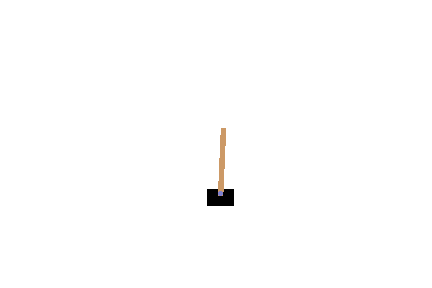
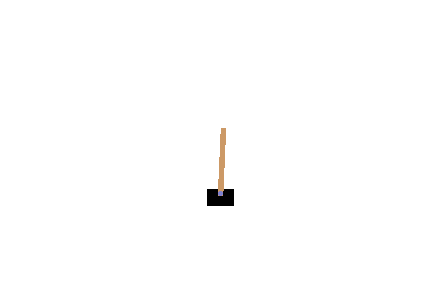
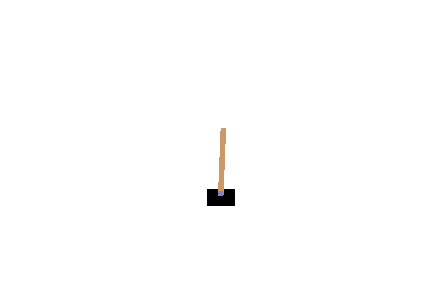
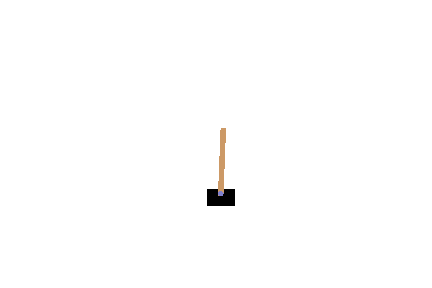
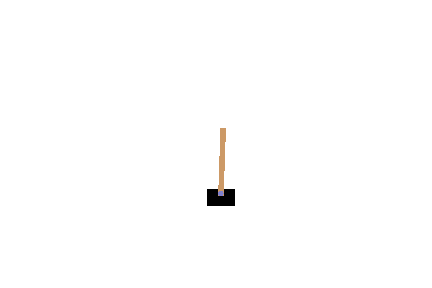
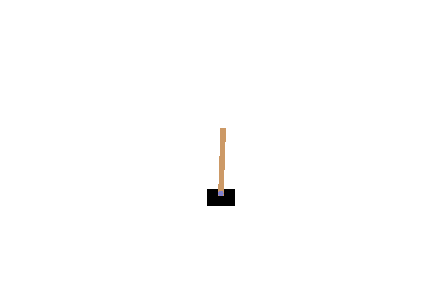
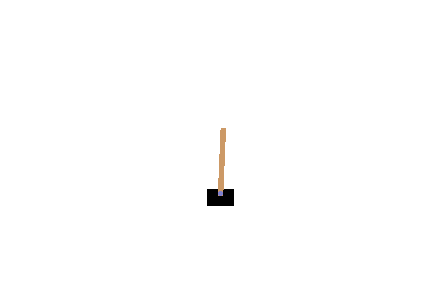
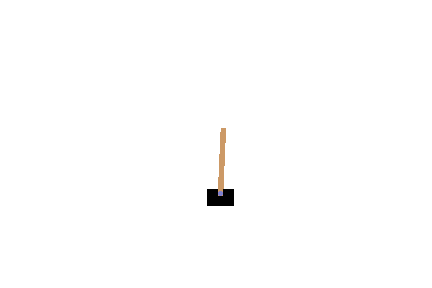
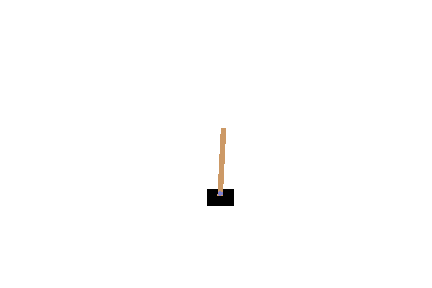
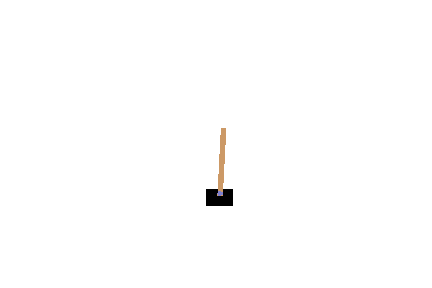
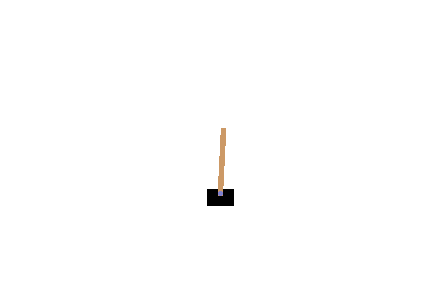
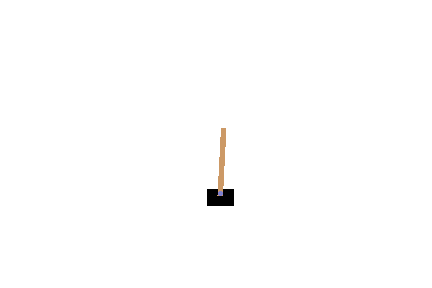
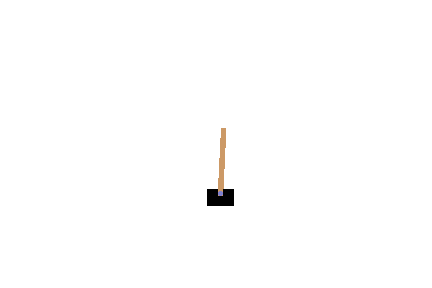
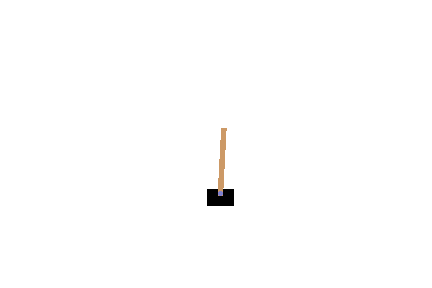
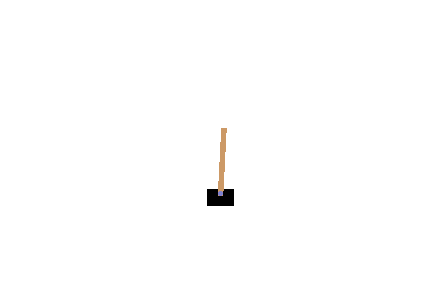
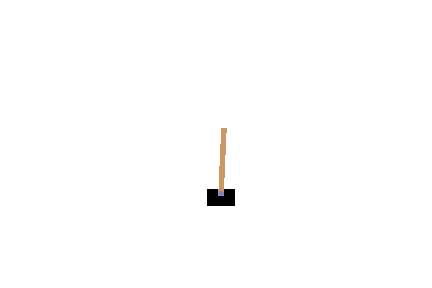
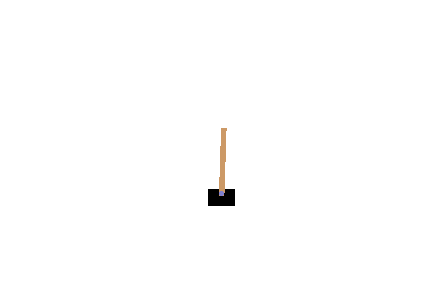
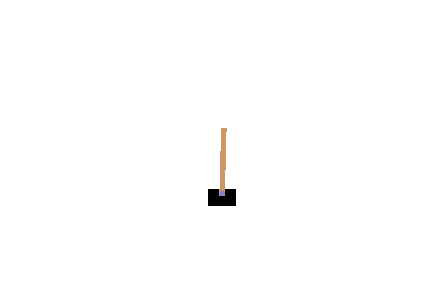
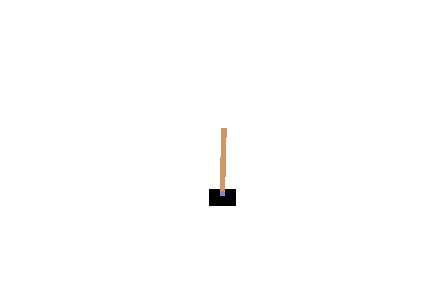
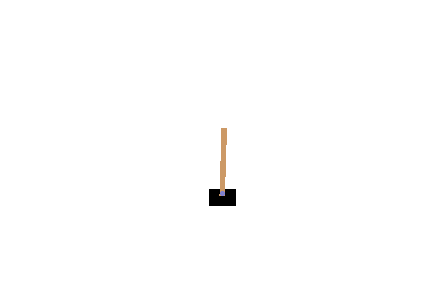
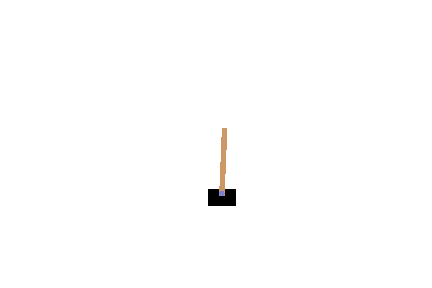
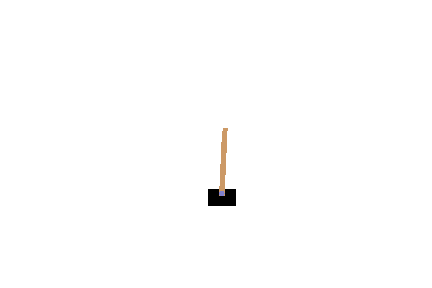
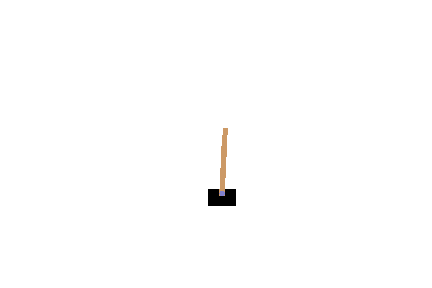
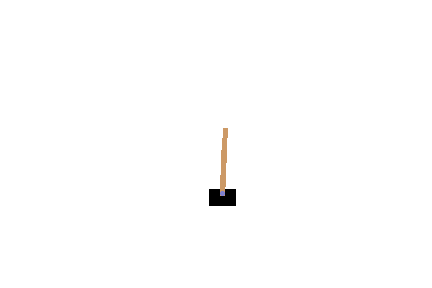
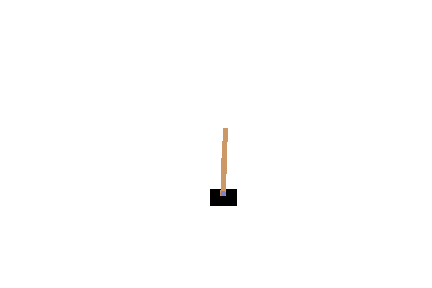
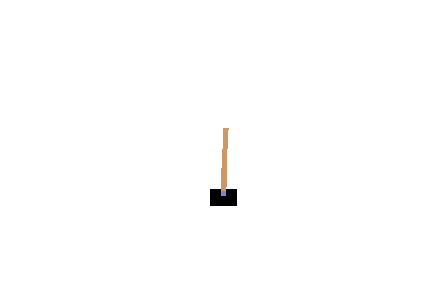
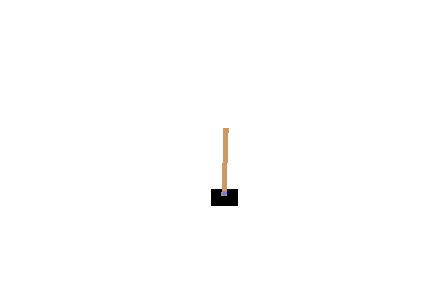
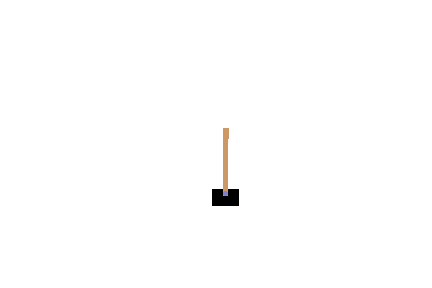
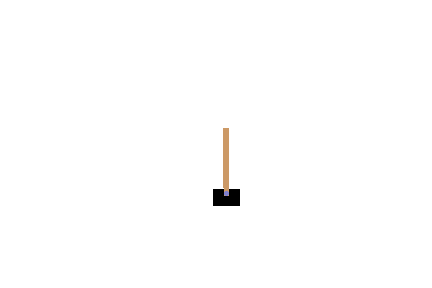
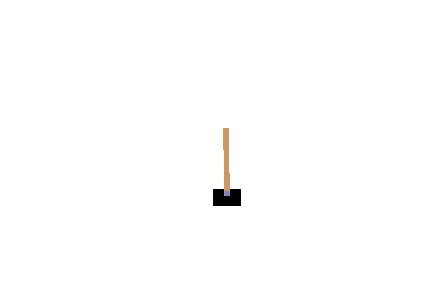
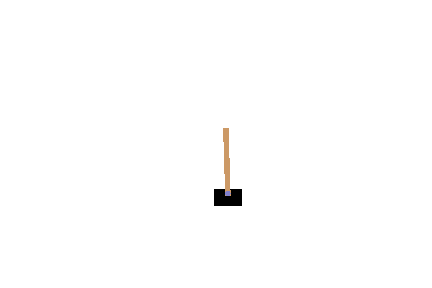
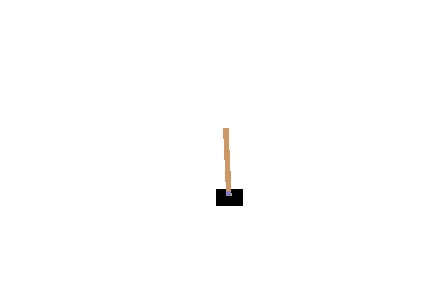
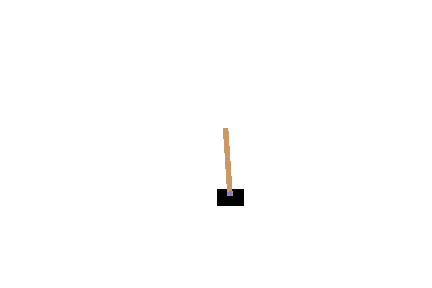
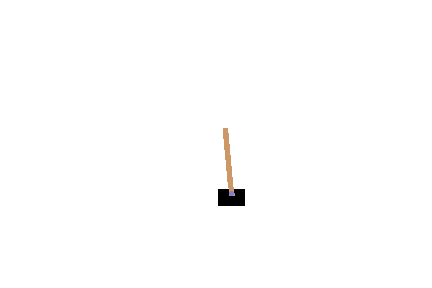
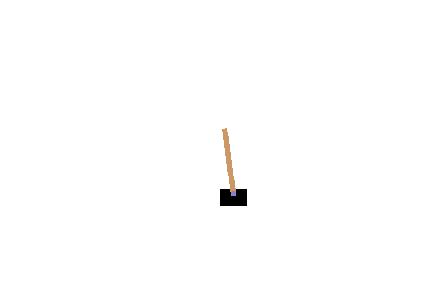
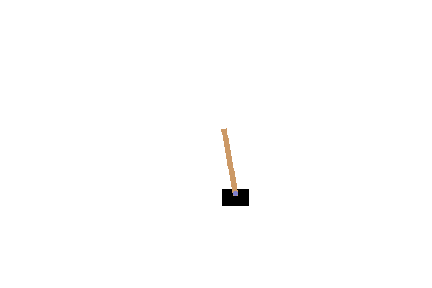

Total reward:  36.0


In [6]:
import gym
env = gym.make('CartPole-v0')
env.seed(1234)
torch.manual_seed(1234)
net = PolicyNet()
optimizer = optim.Adam(net.parameters(), lr=0.01)

run_one_episode(net, env)


Let's train the network!


In [7]:
train_policy(net, optimizer, env)

Episode 0, Avg length: 0.75 
Episode 100, Avg length: 50.74 
Episode 200, Avg length: 193.91 
Episode 300, Avg length: 110.23 
Episode 400, Avg length: 196.37 


And evaluate again!


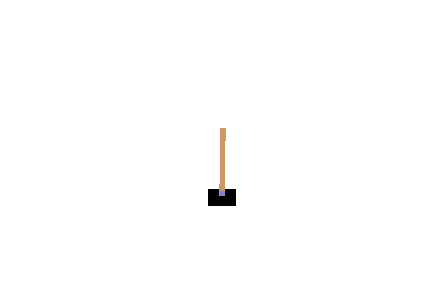
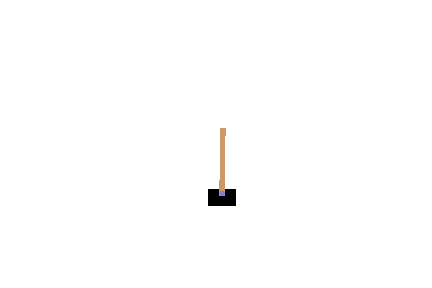
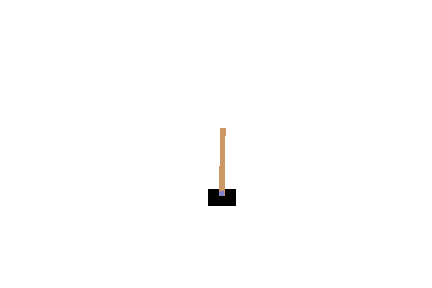
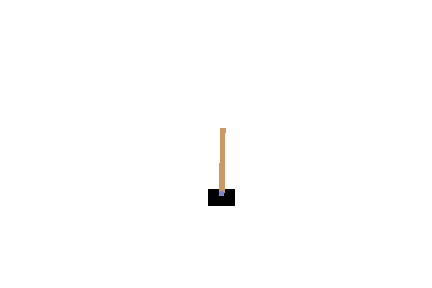
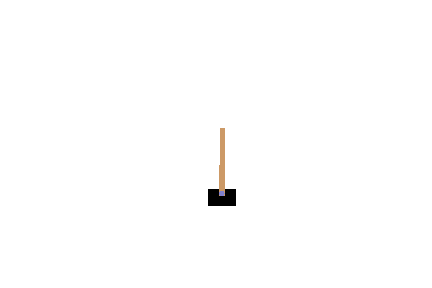
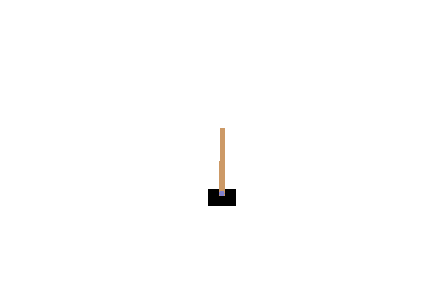
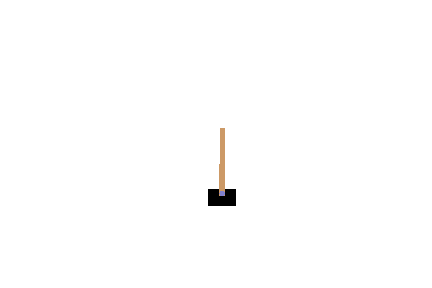
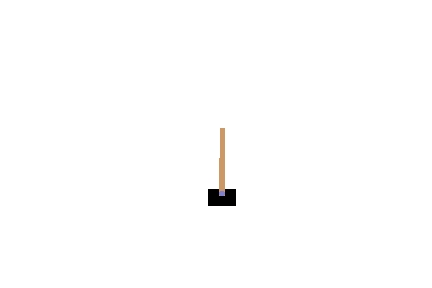
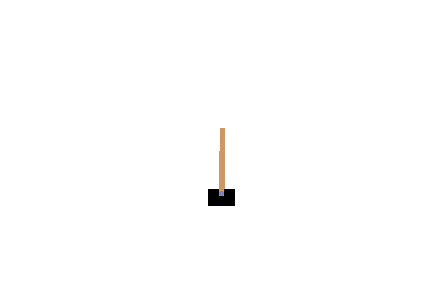
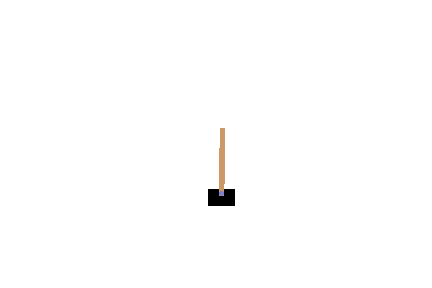
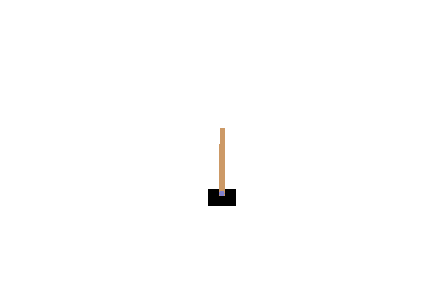
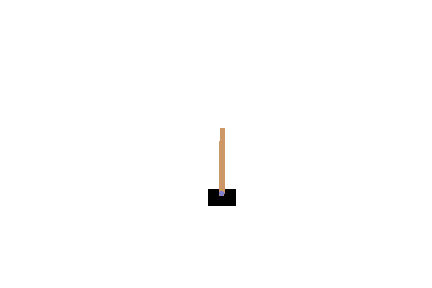
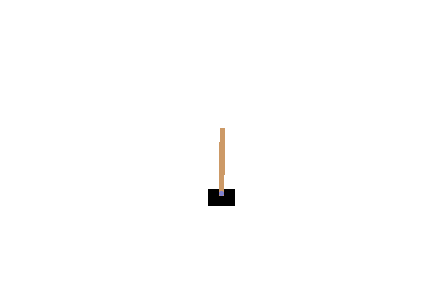
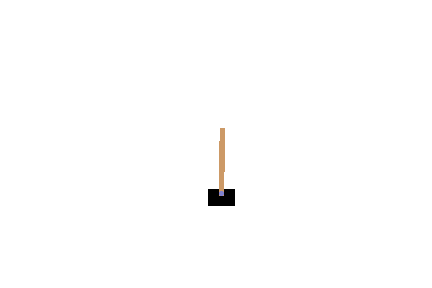
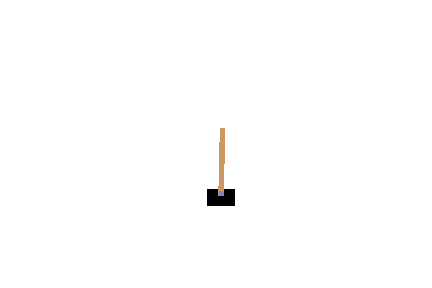
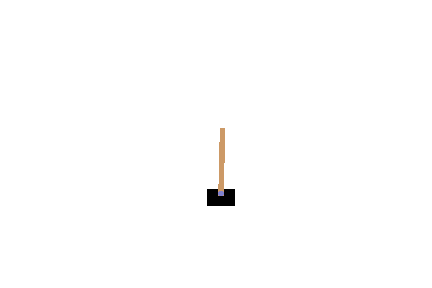
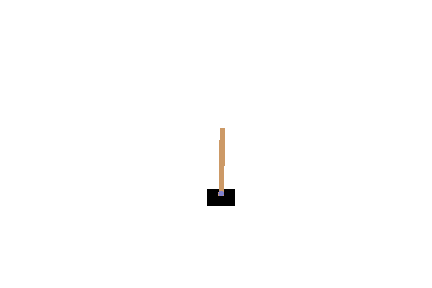
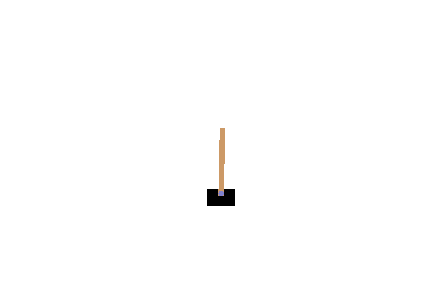
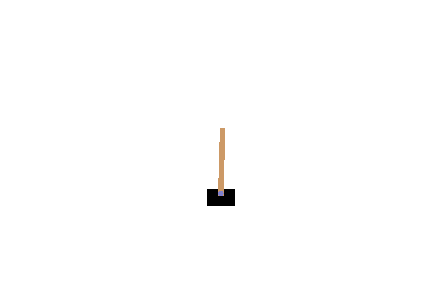
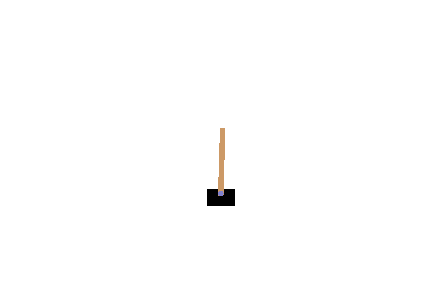
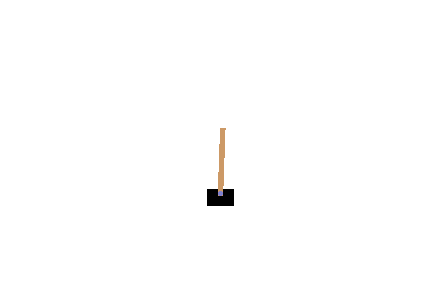
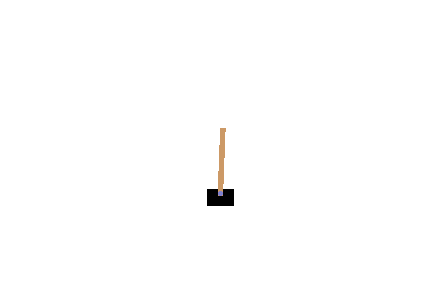
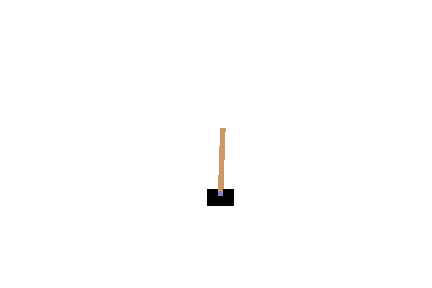
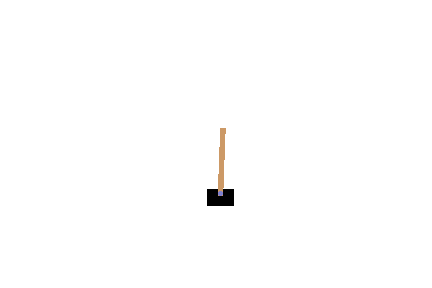
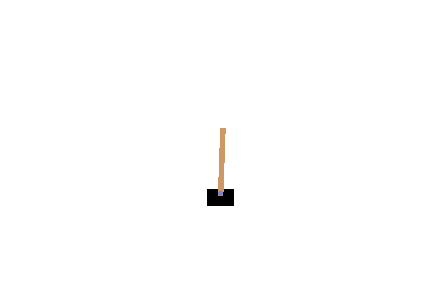
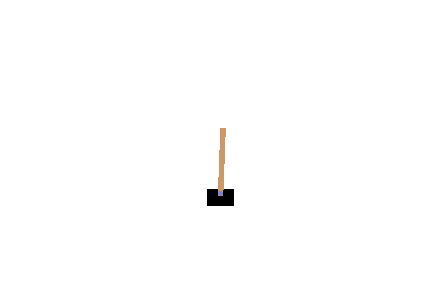
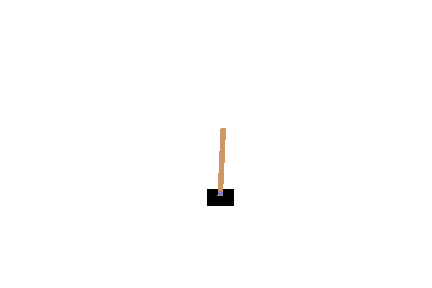
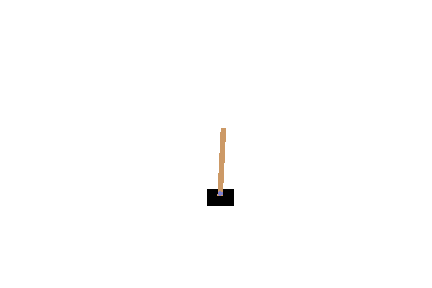
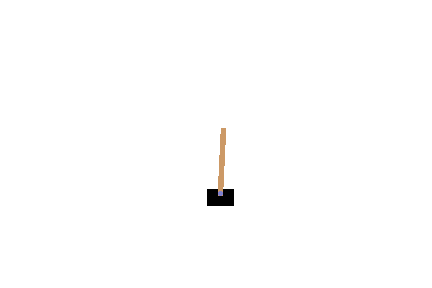
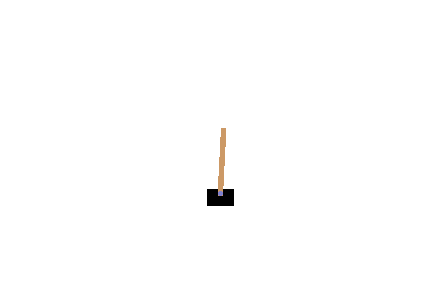
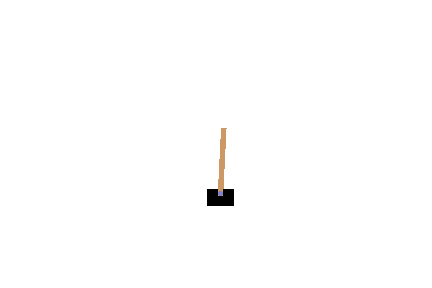
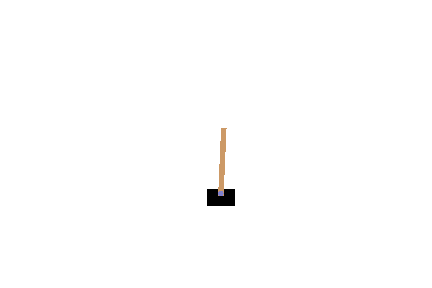
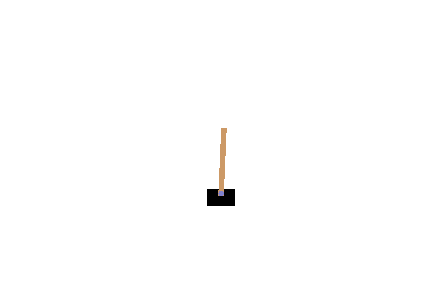
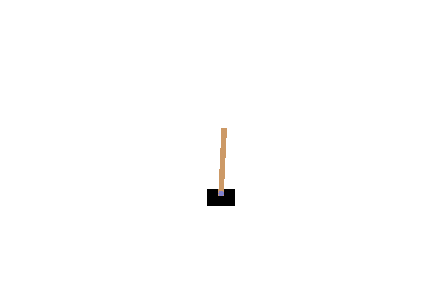
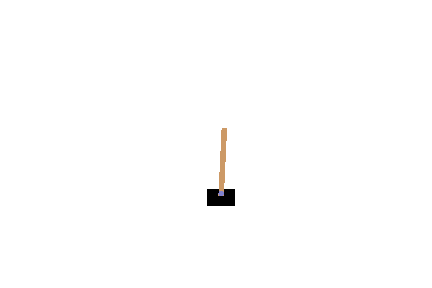
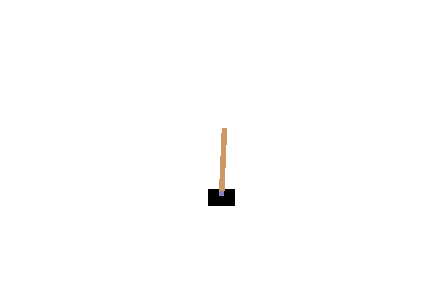
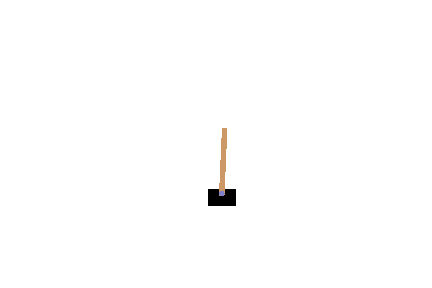
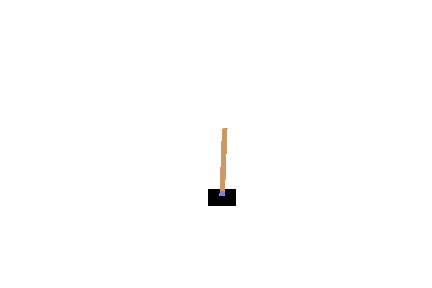
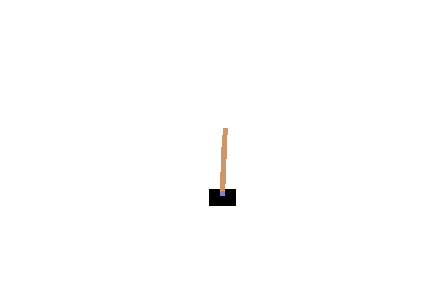
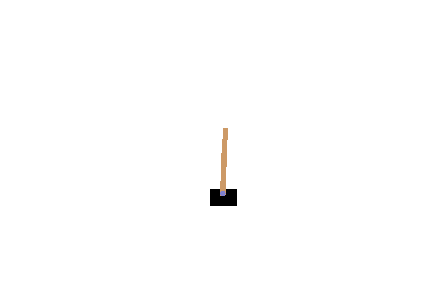
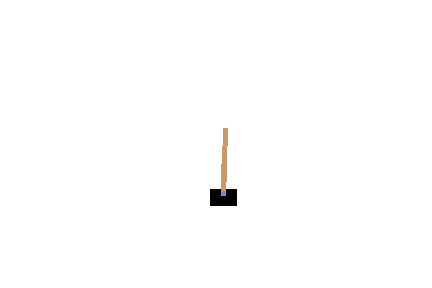
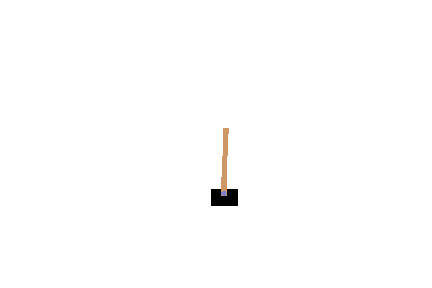
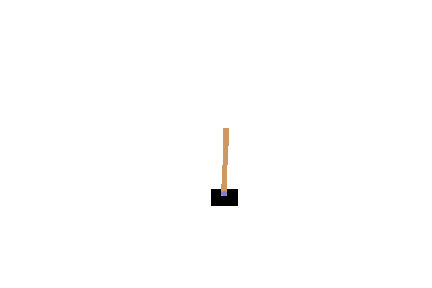
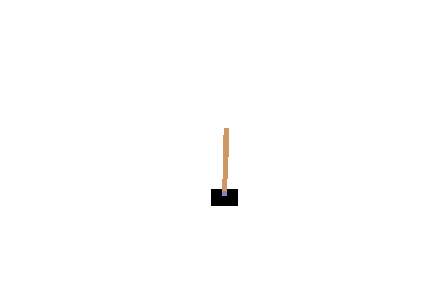
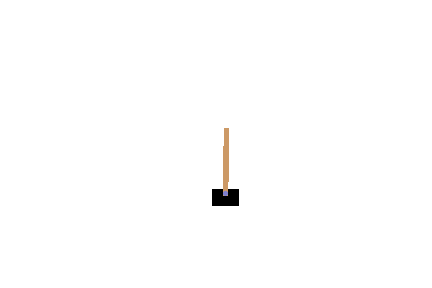
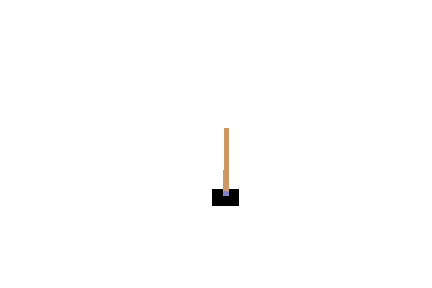
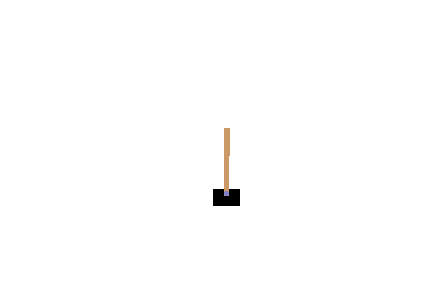
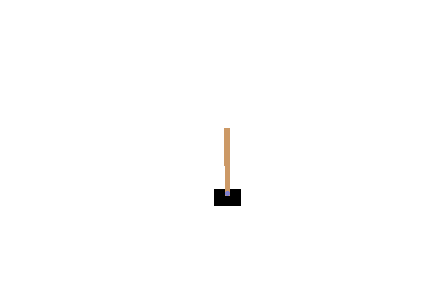
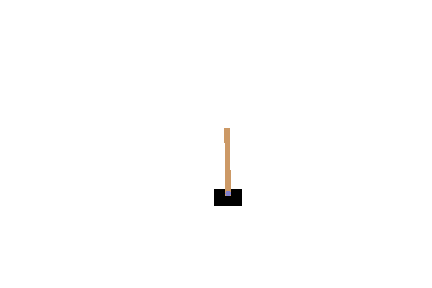
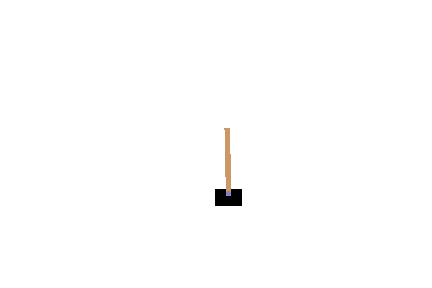
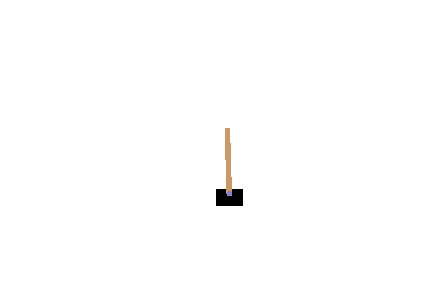
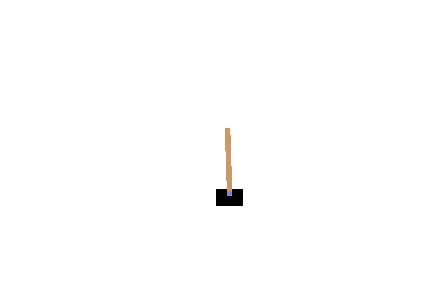
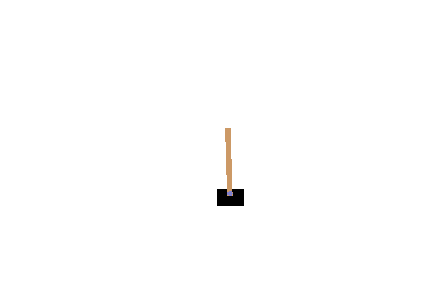
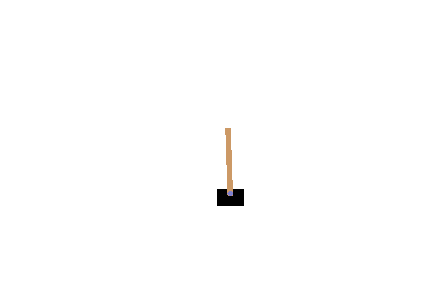
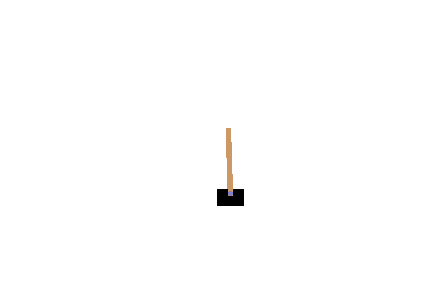
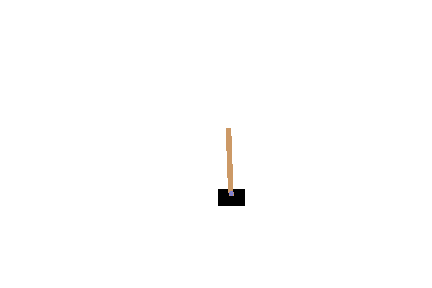
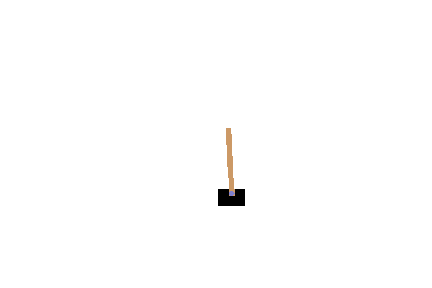
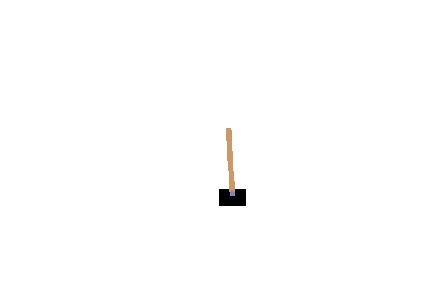
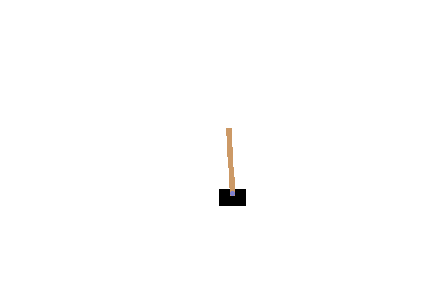
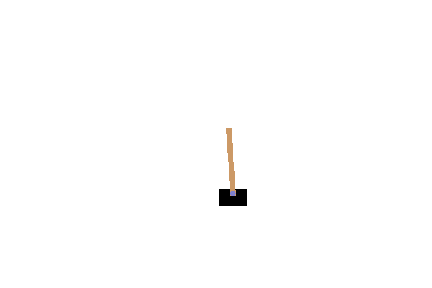
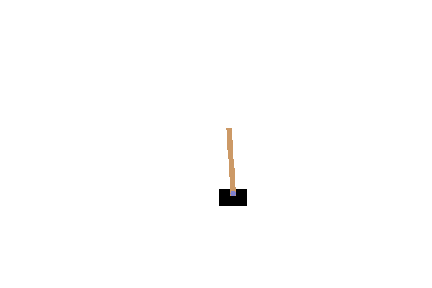
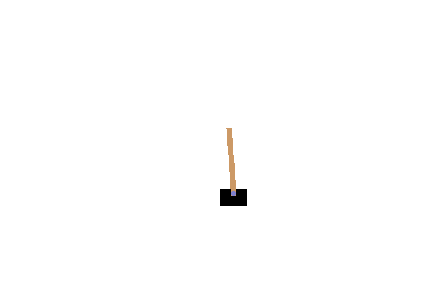
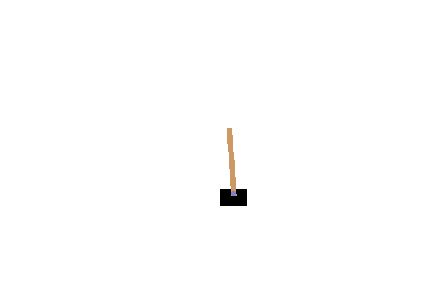
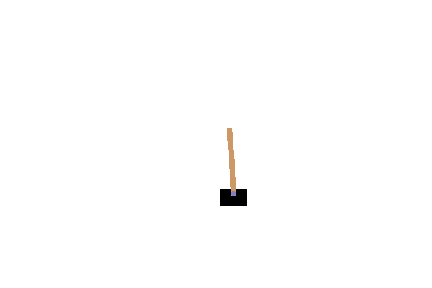
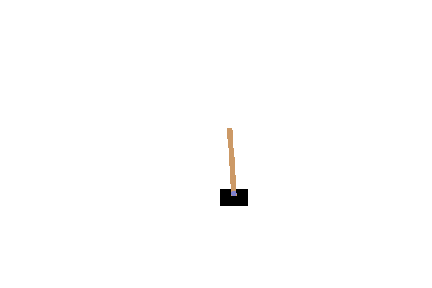
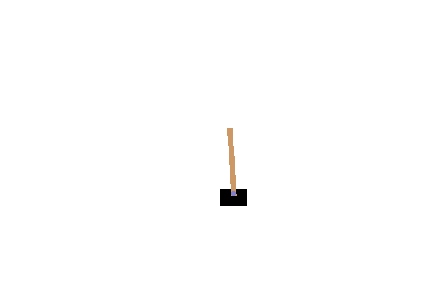
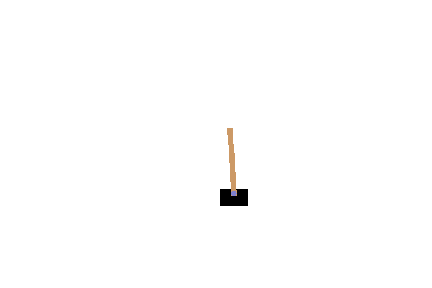
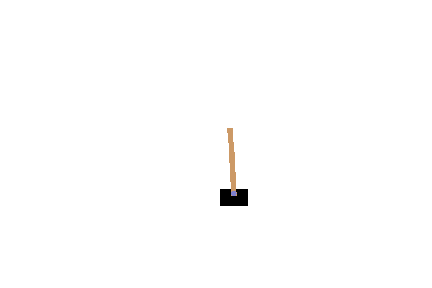
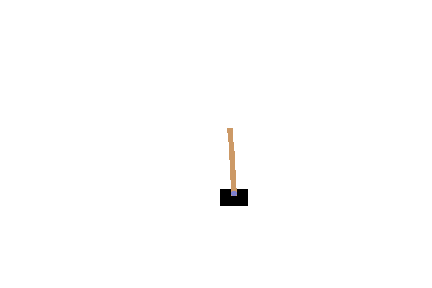
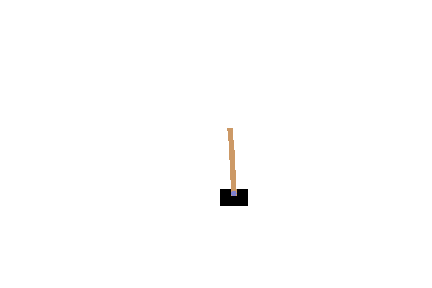
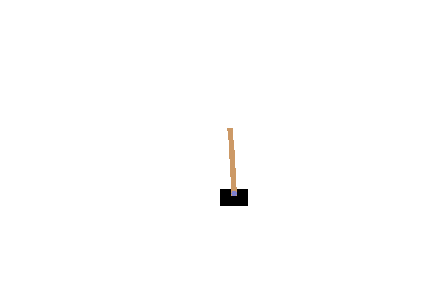
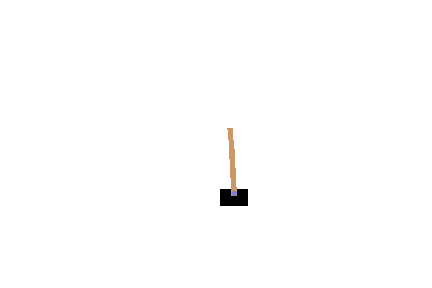
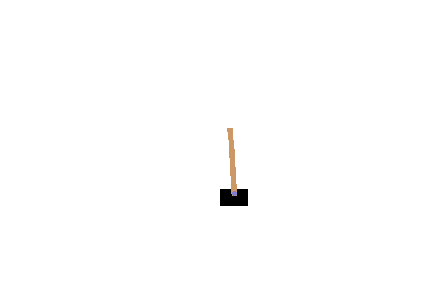
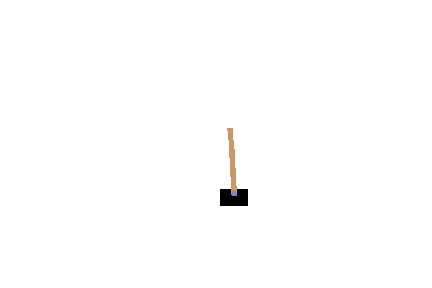
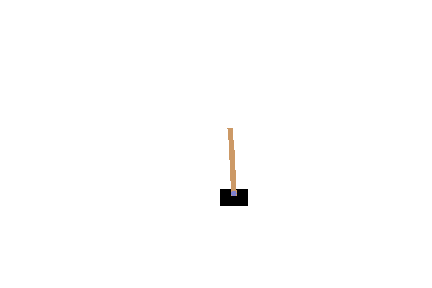
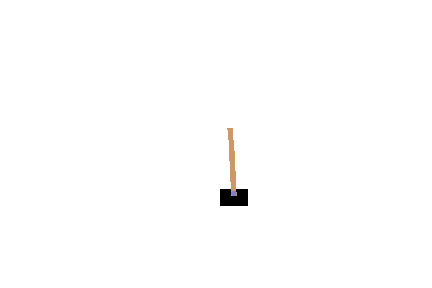
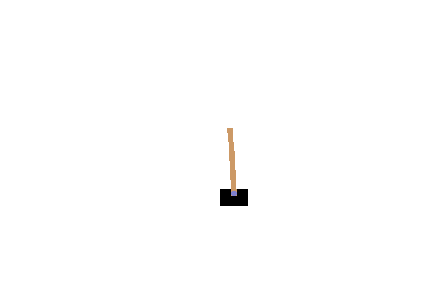
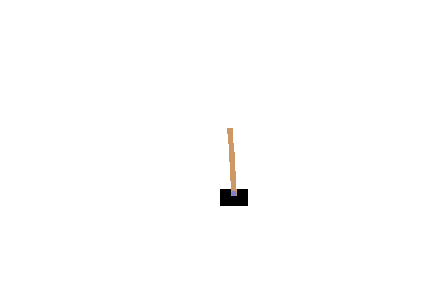
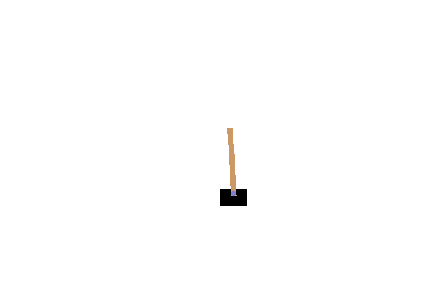
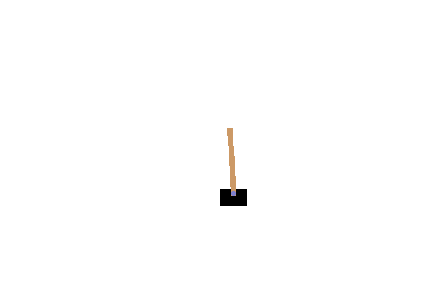
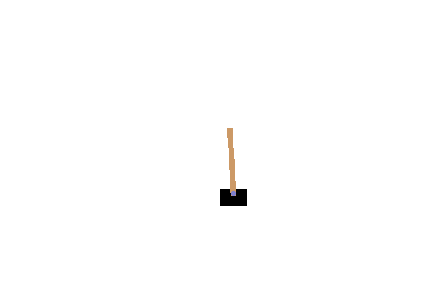
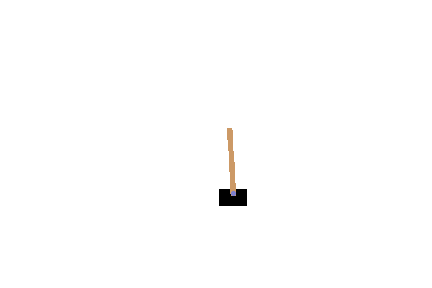
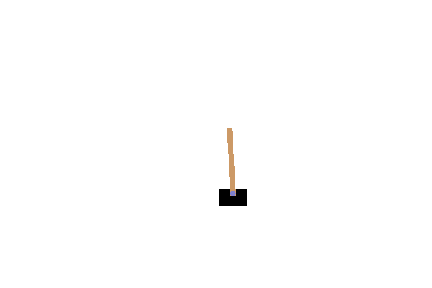
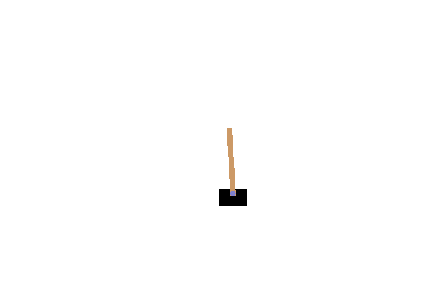
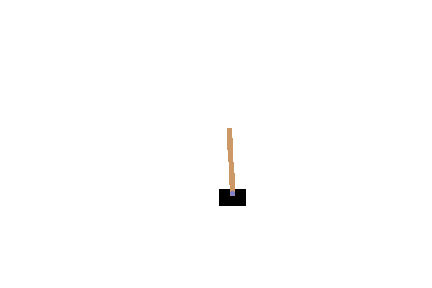
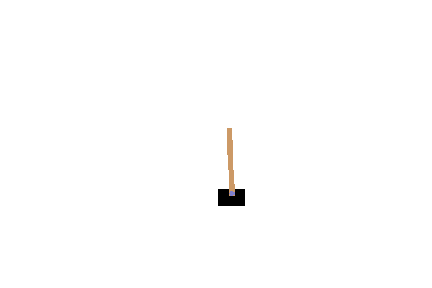
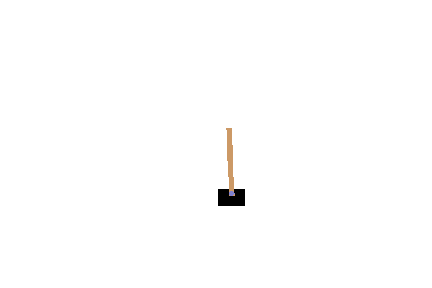
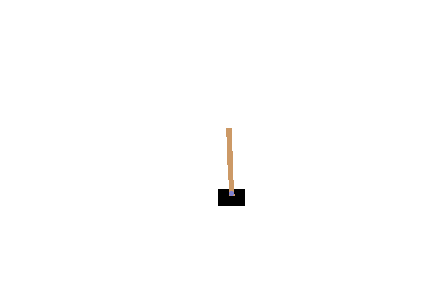
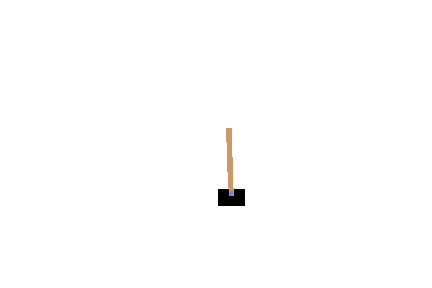
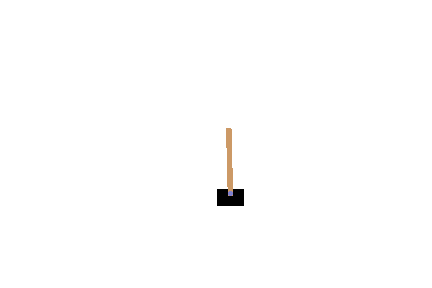
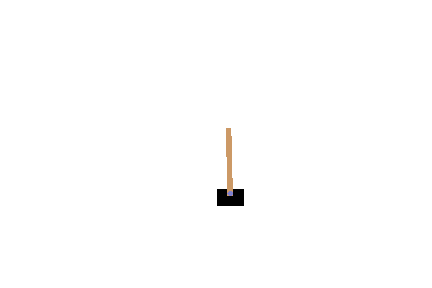
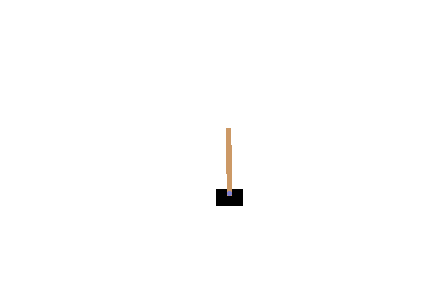
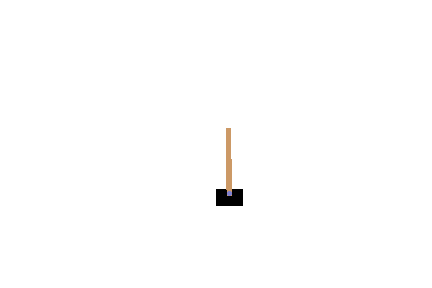
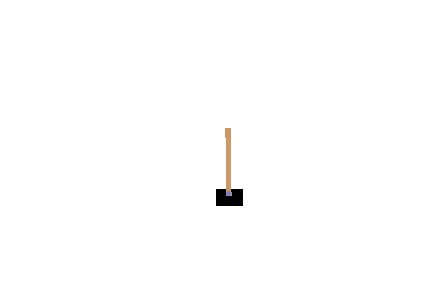
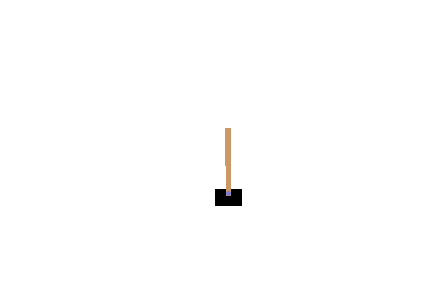
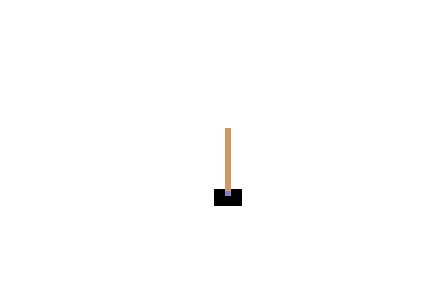
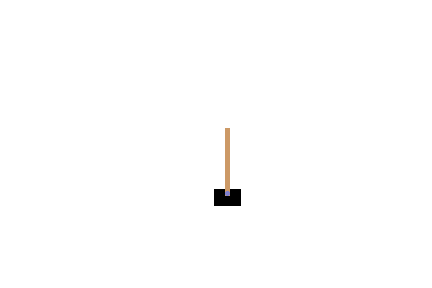
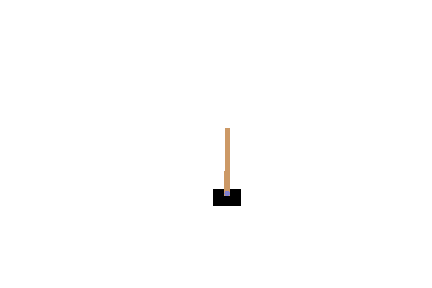
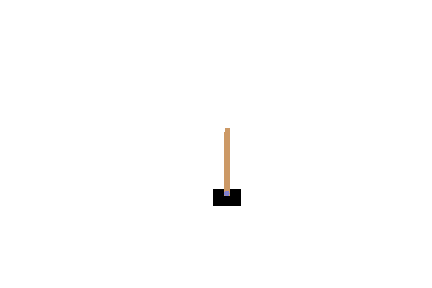
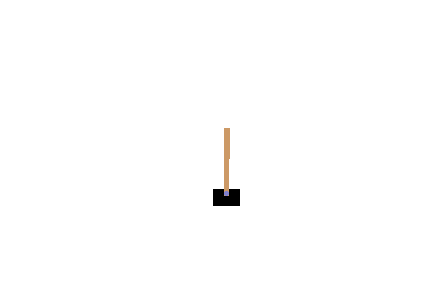
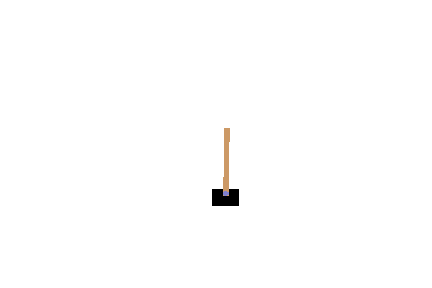
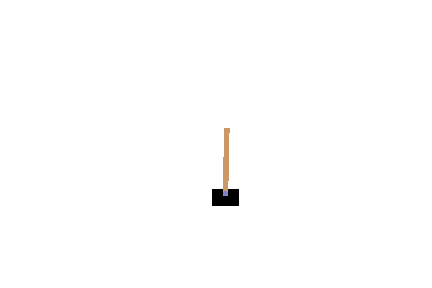
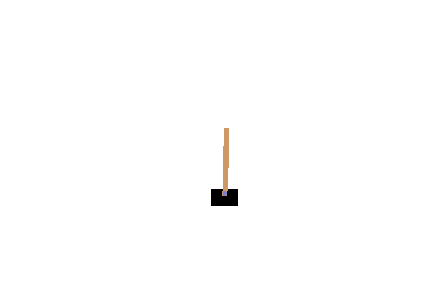
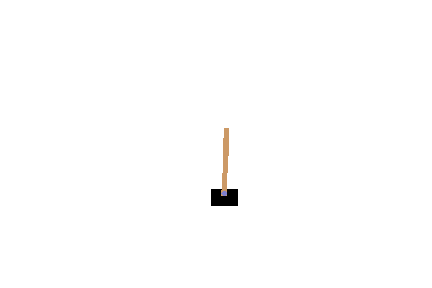
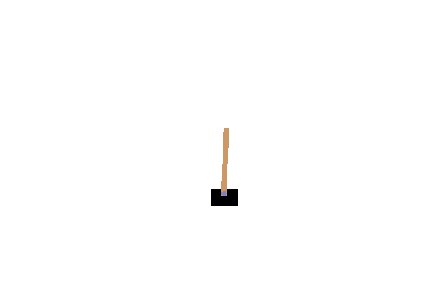
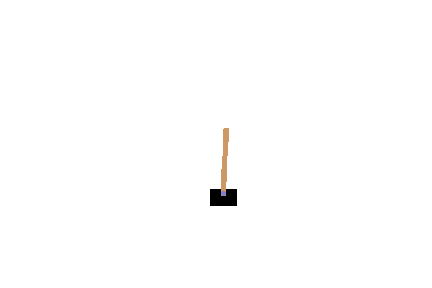
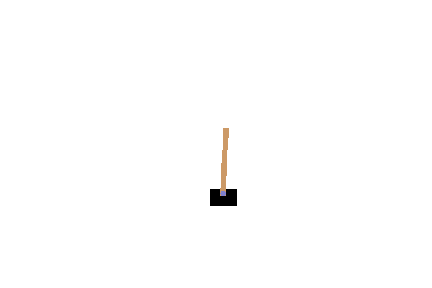
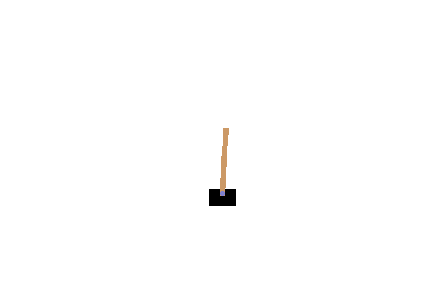
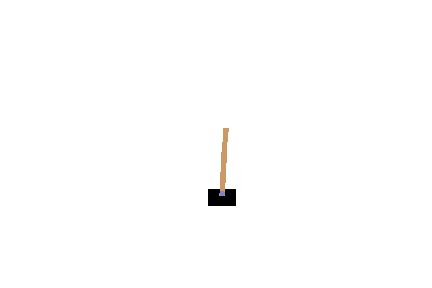
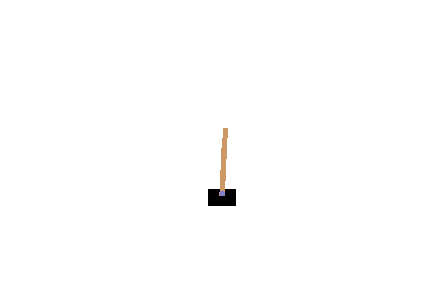
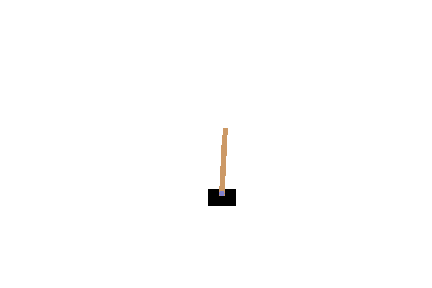
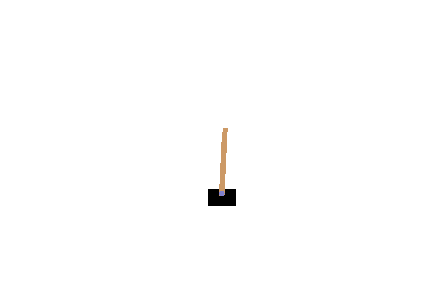
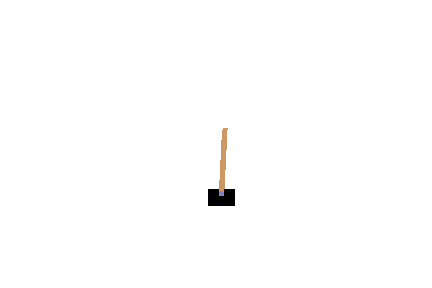
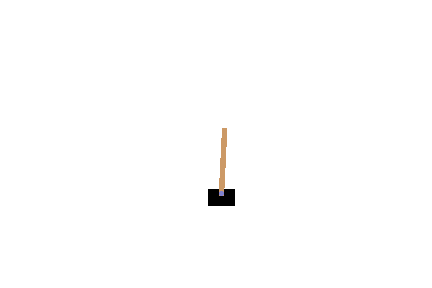
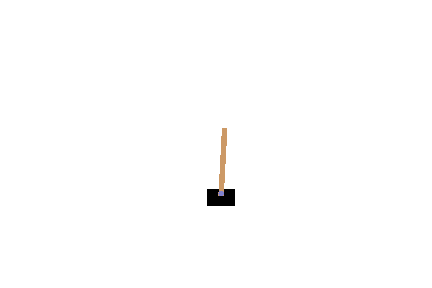
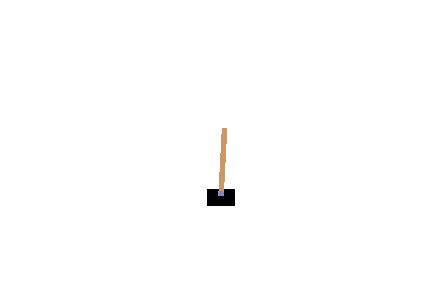
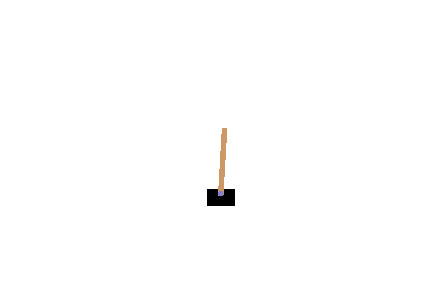
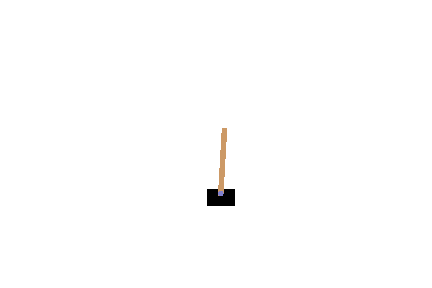
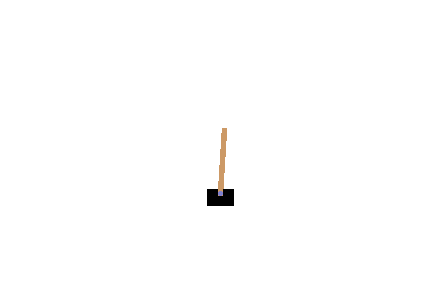
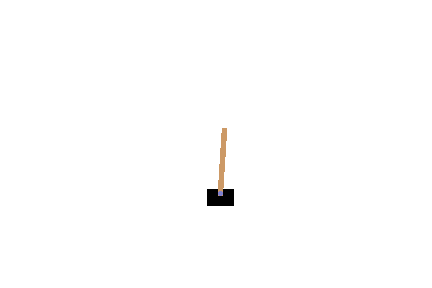
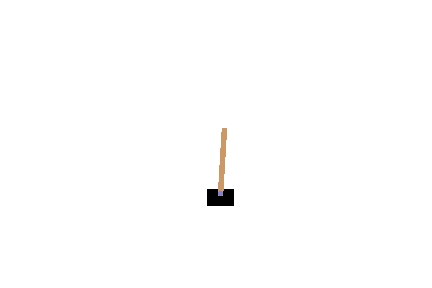
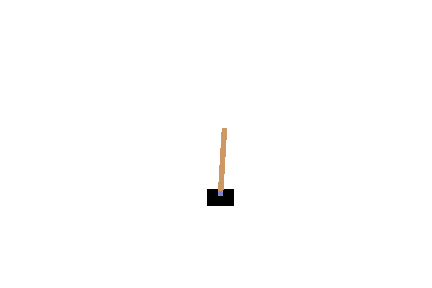
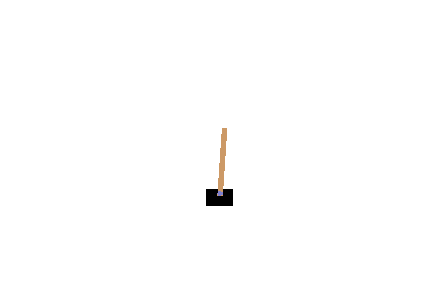
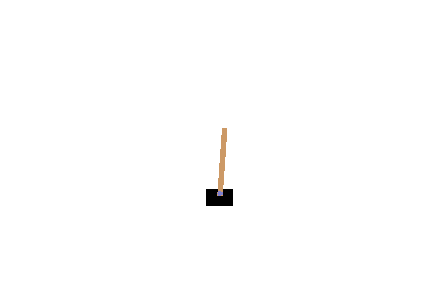
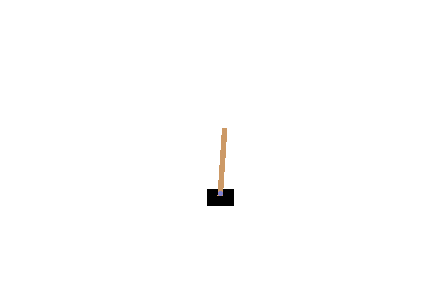
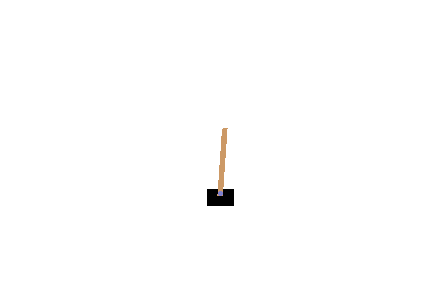
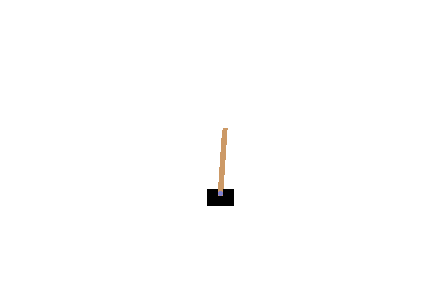
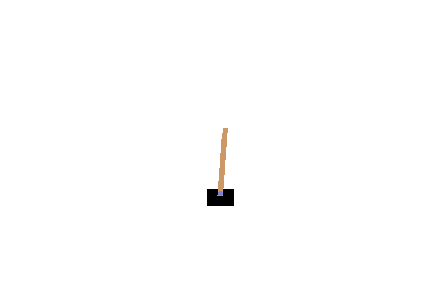
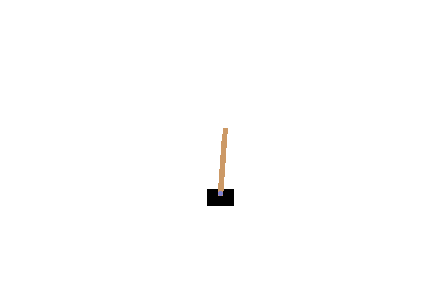
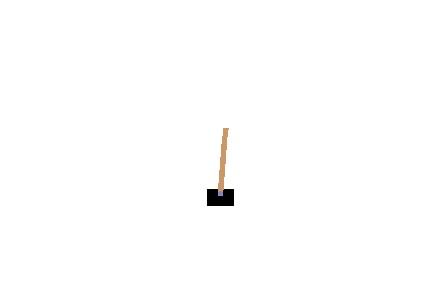
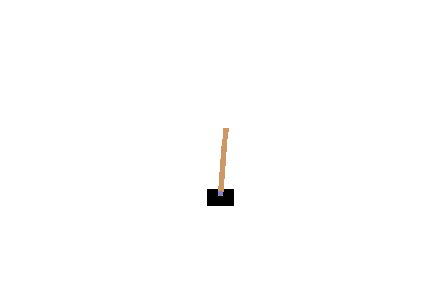
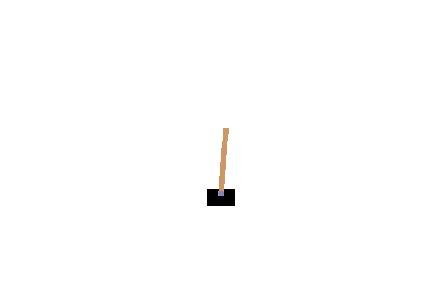
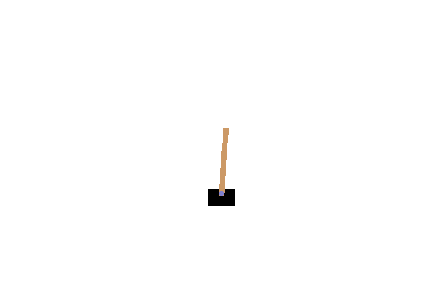
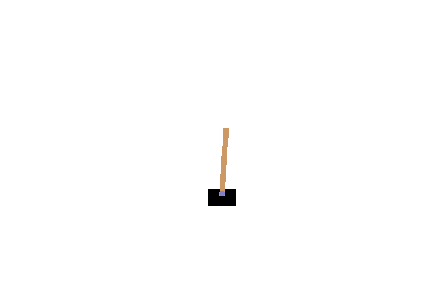
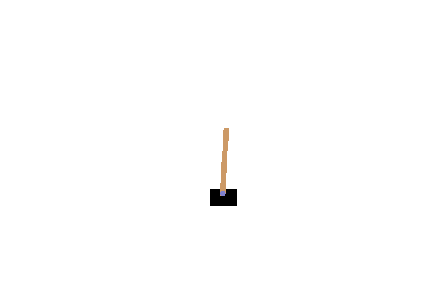
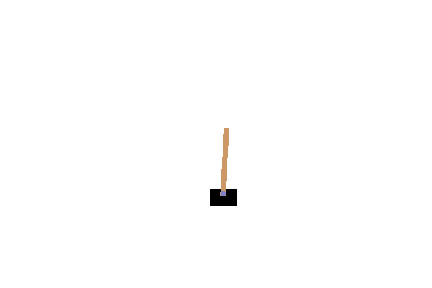
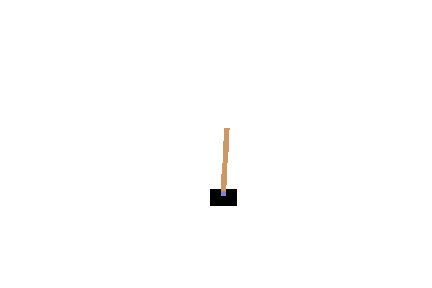
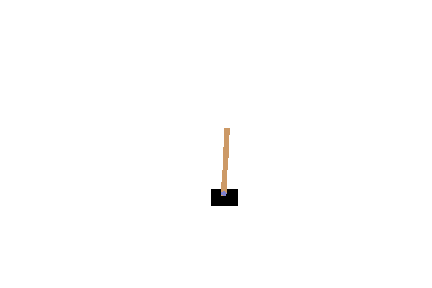
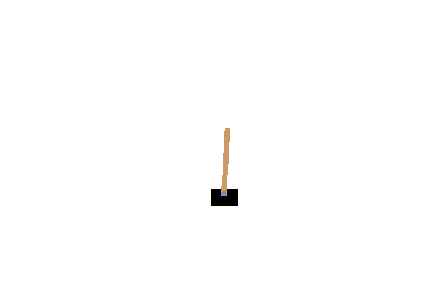
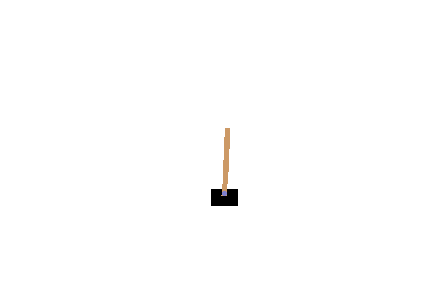
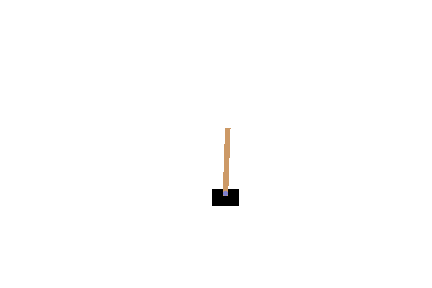
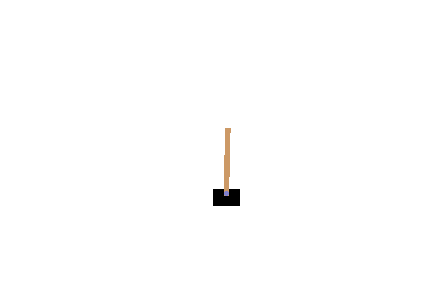
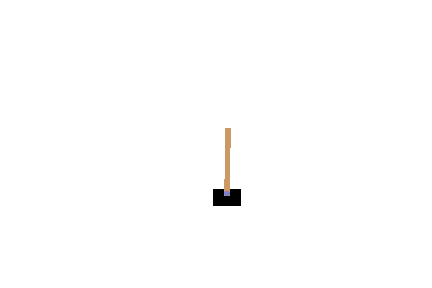
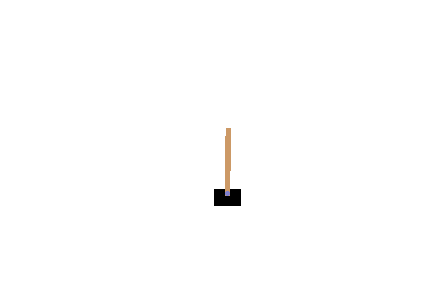
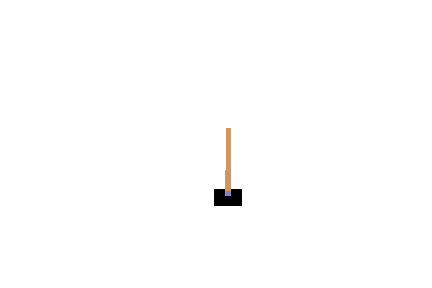
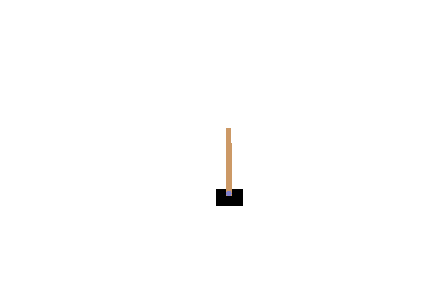
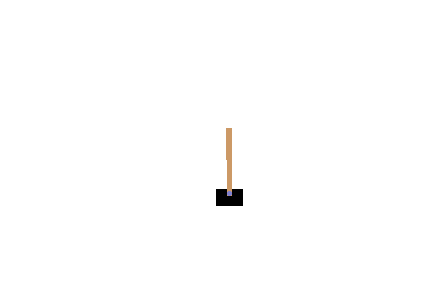
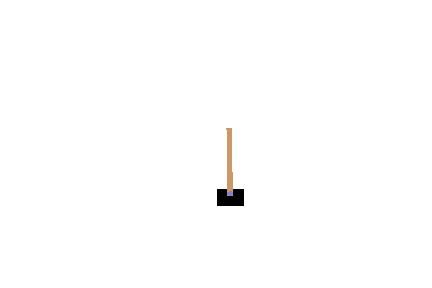
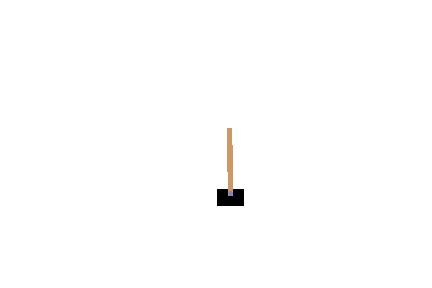
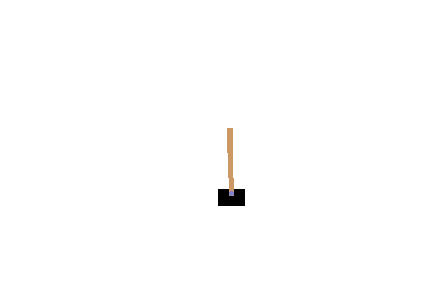
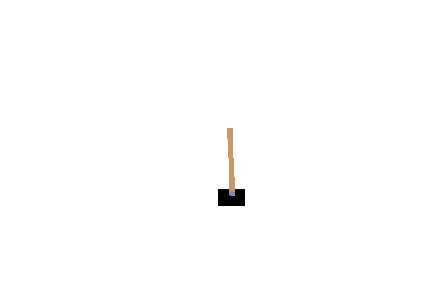
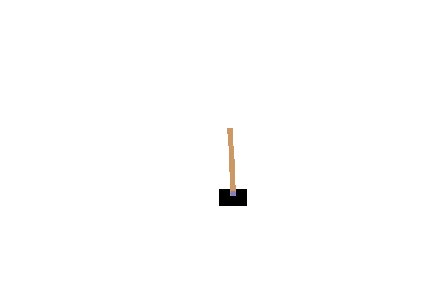
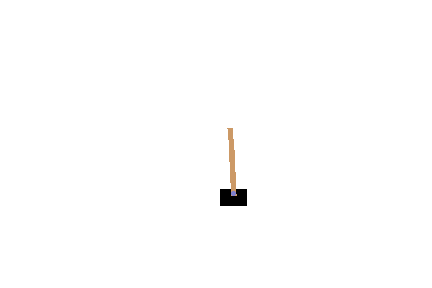
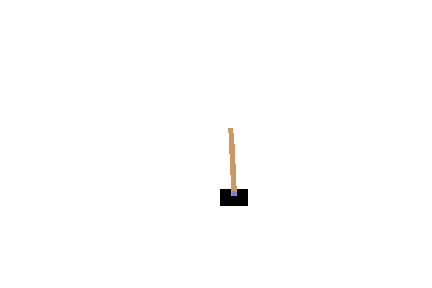
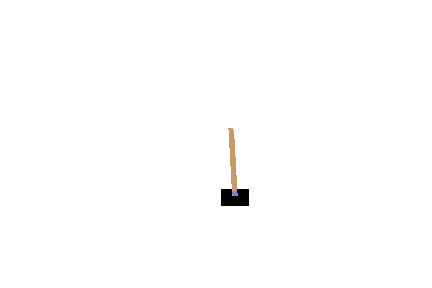
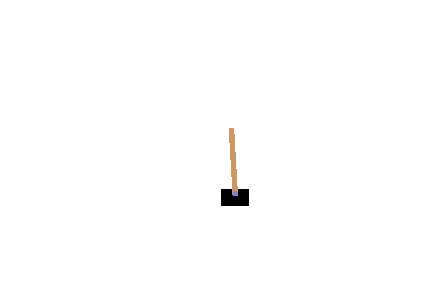
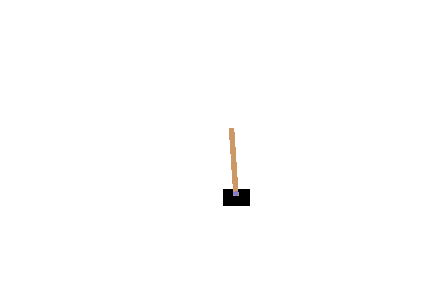
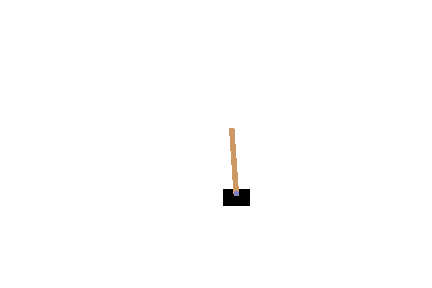
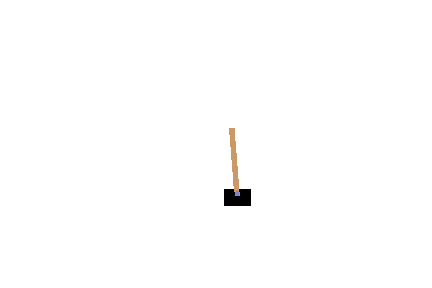
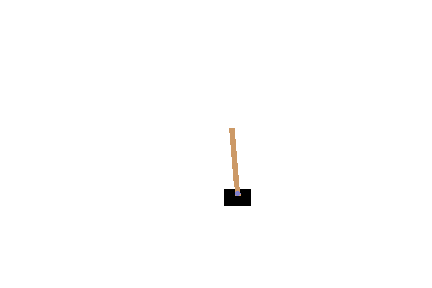
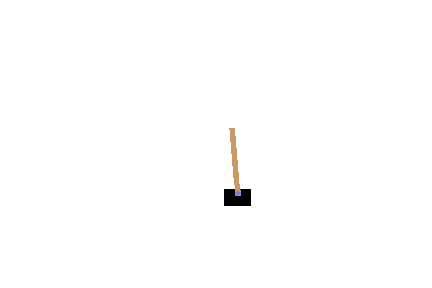
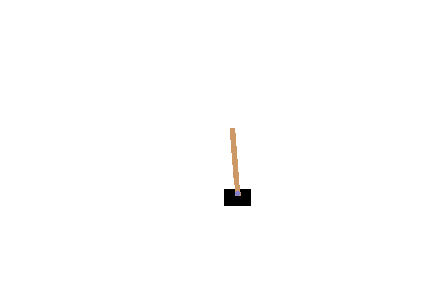
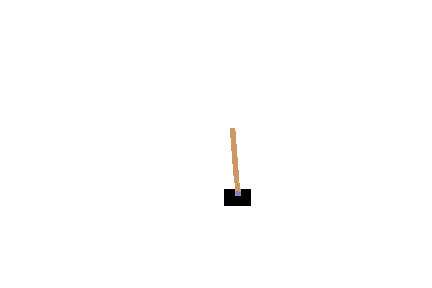
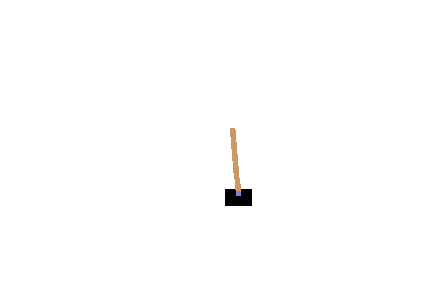
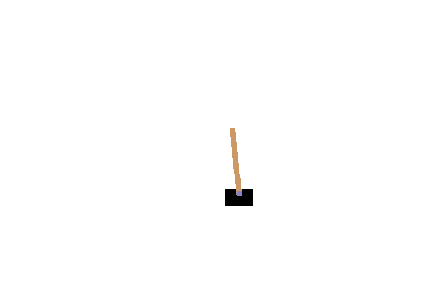
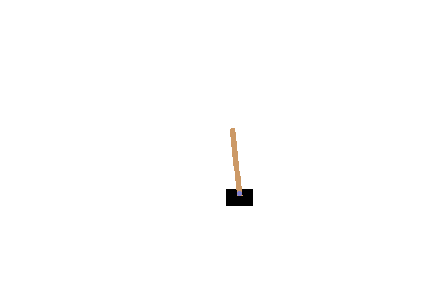
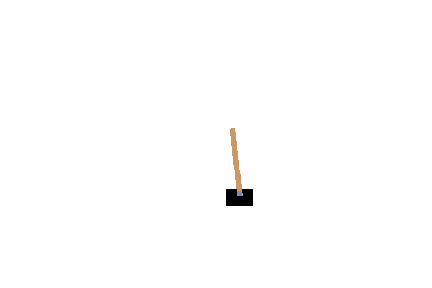
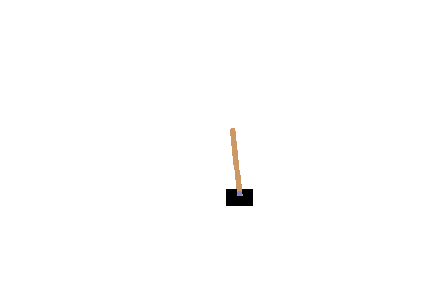
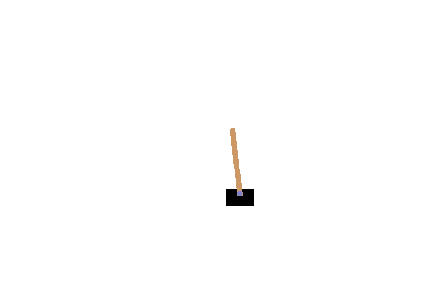
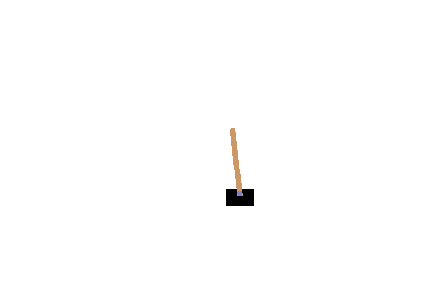
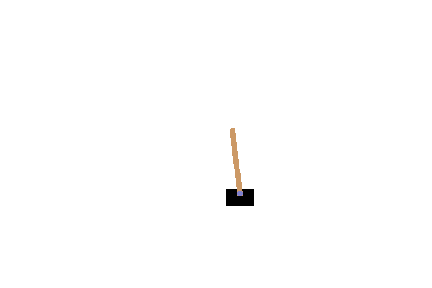
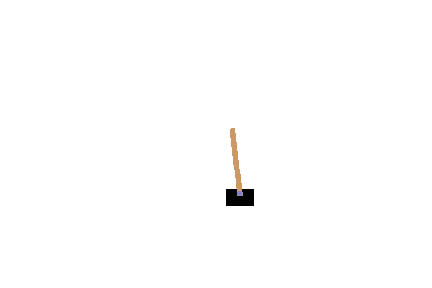
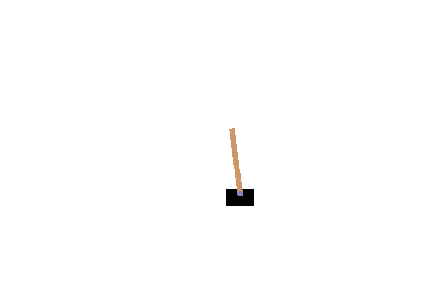
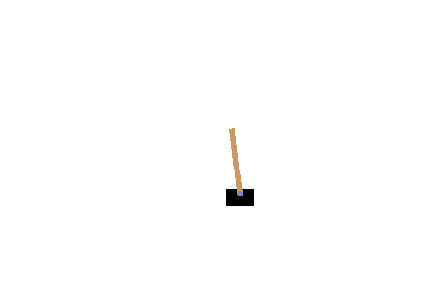
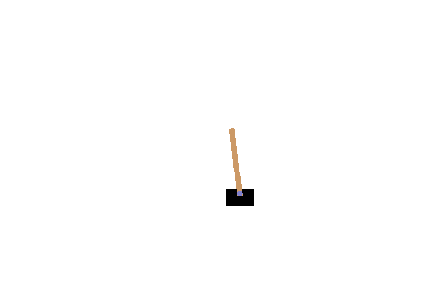
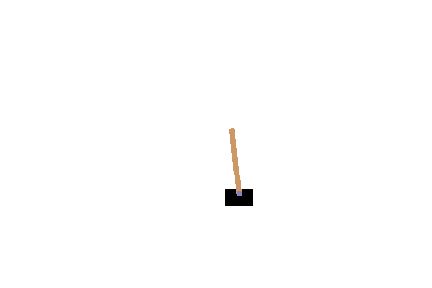
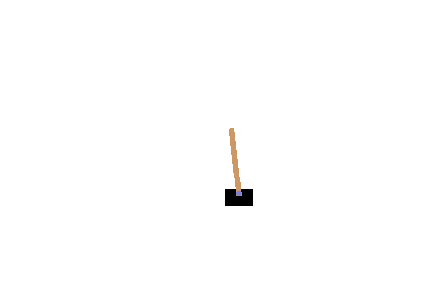
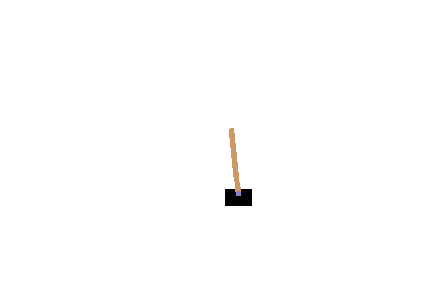
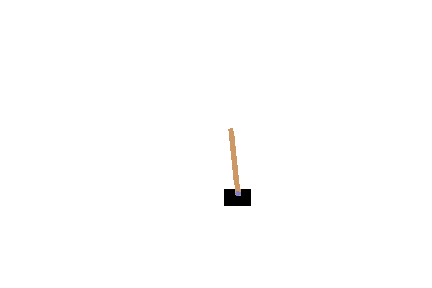
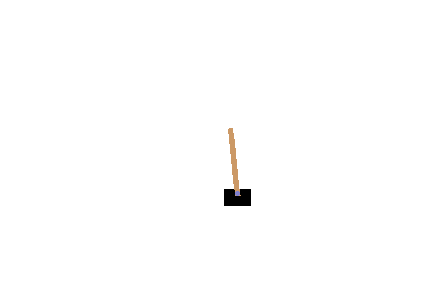
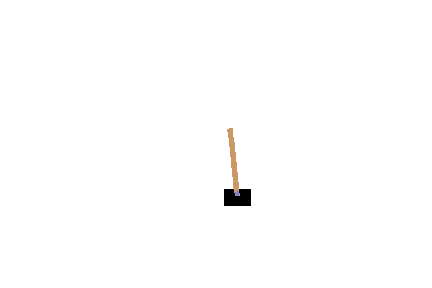
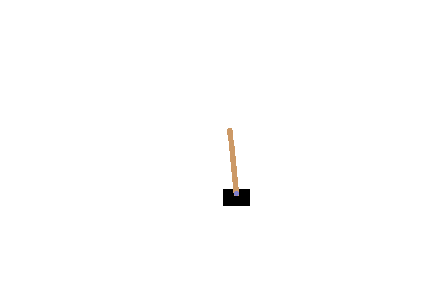
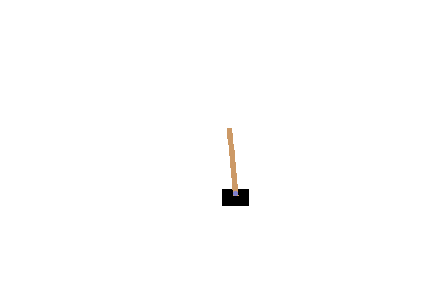
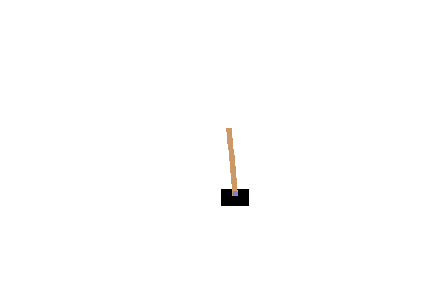
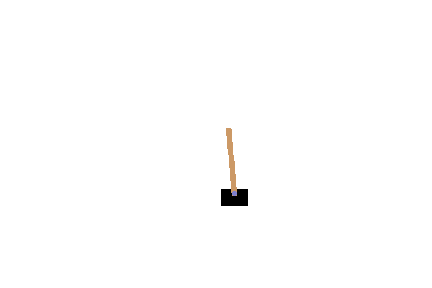
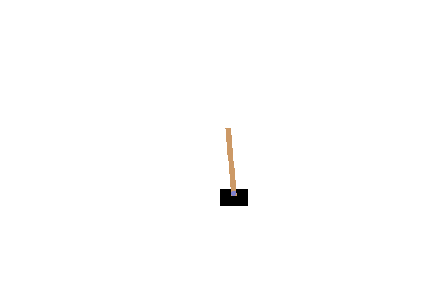
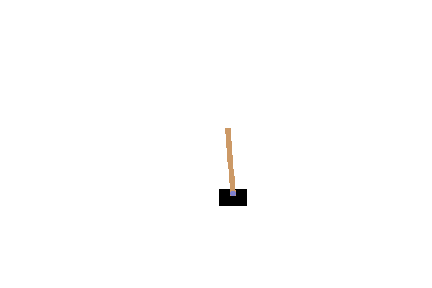
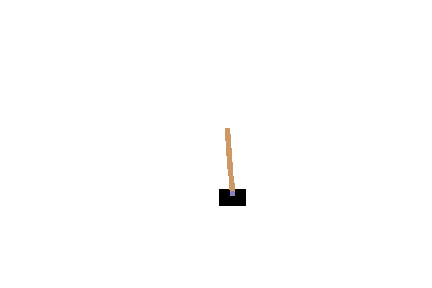
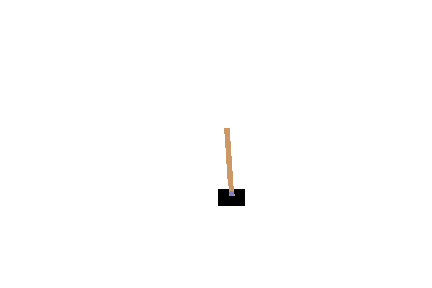
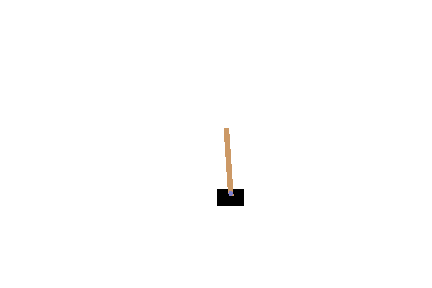
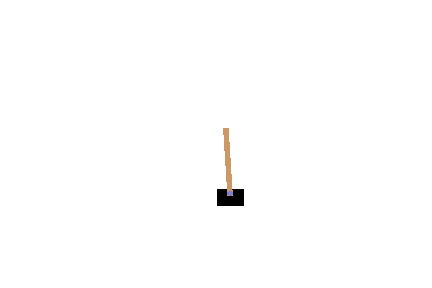
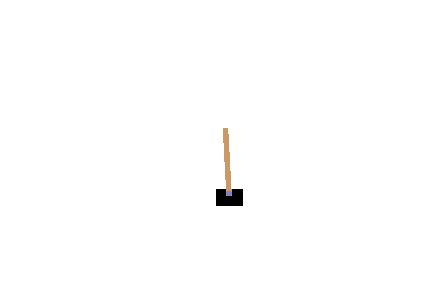
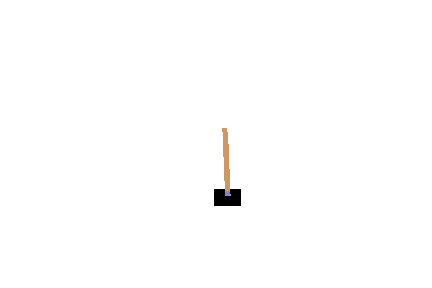
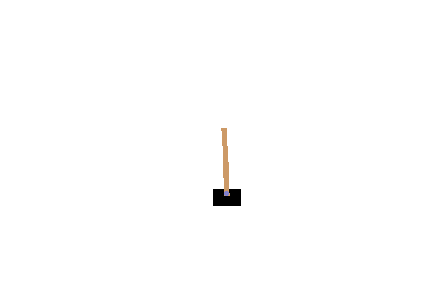
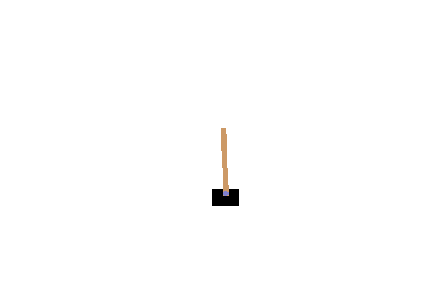
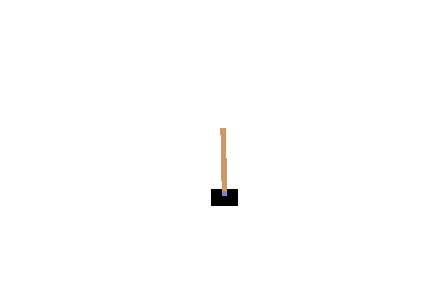
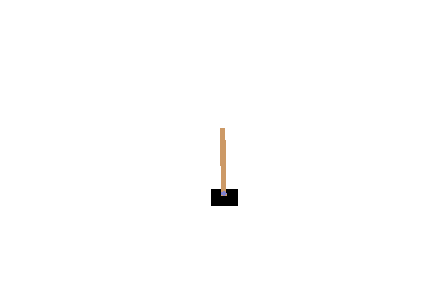
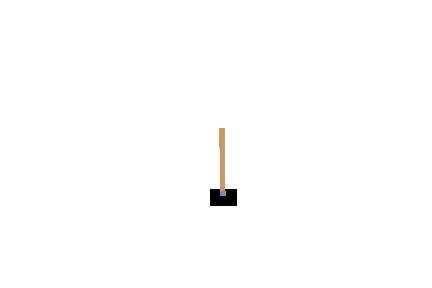
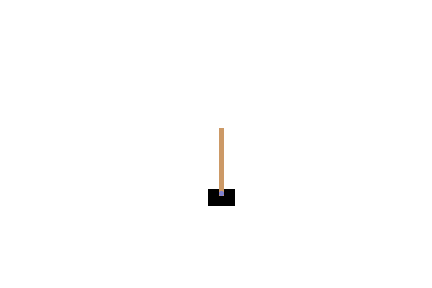
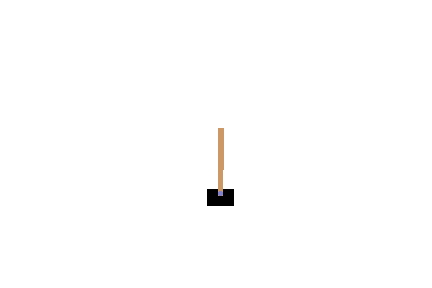

Total reward:  200.0


In [8]:
run_one_episode(net, env)